<a href="https://colab.research.google.com/github/daniil-chepela/twitter-geolocation/blob/main/Geotagging_identify_relevant_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import of twitter training database

In [ ]:
!pip install geopandas
import pandas as pd
import numpy as np
import geopandas
import folium
from folium import plugins

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def get_geometry(df):
  geometry = geopandas.points_from_xy(df.lon, df.lat)
  geo_data = [[point.xy[1][0], point.xy[0][0]] for point in geometry ]
  return geo_data

def plot_heatmap(df):
  map = folium.Map(location = [15,30], tiles='Cartodb dark_matter', zoom_start = 2)
  heat_data = get_geometry(df)
  plugins.HeatMap(heat_data).add_to(map)
  return map

def plot_points(df):
  map = folium.Map(location = [15,30], tiles='Cartodb dark_matter', zoom_start = 2)
  if df.size > 2:
    for point in get_geometry(df):
      folium.Marker(point).add_to(map)
  else:
    point = [df.lat, df.lon]
    folium.Marker(point).add_to(map)
  return map

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Database needs a lot of cleaning before usage

In [ ]:
def is_number(n):
    try:
        float(n)   # Type-casting the string to `float`.
                   # If string is not a valid `float`, 
                   # it'll raise `ValueError` exception
    except ValueError:
        return False
    return True

tweets_full_df = pd.read_csv('/content/drive/MyDrive/training_data.csv', on_bad_lines='skip')
tweets_full_df.dropna(inplace=True)
tweets_full_df['is_lat'] = tweets_full_df['lat'].apply(is_number)
tweets_full_df['is_lon'] = tweets_full_df['lon'].apply(is_number)
tweets_full_df['columns_to_drop'] = ~(tweets_full_df['is_lat'] & tweets_full_df['is_lon'])
tweets_full_df.drop(tweets_full_df[tweets_full_df['columns_to_drop']==True].index, inplace=True)
tweets_full_df.drop(['is_lat', 'is_lon', 'columns_to_drop'], axis=1, inplace=True)
tweets_full_df['lat'] = tweets_full_df['lat'].apply(float)
tweets_full_df['lon'] = tweets_full_df['lon'].apply(float)
tweets_full_df.drop(tweets_full_df[tweets_full_df['lat'] > 90].index, inplace=True)



tweets_full_df.sample(n=10)

,tweet_text,lang,timestamp,lat,lon
4251441,USA all military power must be destroyed right...,en,2021-08-29T12:12:23.000Z,22.612706,88.352242
1911714,@BurkhalterEddie Alabama state officials are w...,en,2021-08-14T10:39:07.000Z,34.443806,-86.940582
3359449,羽南選手、お誕生日おめでとう御座います。素敵な一年をお過ごし下さい。いつも素敵な笑顔を有難う...,ja,2021-08-11T09:52:26.000Z,35.881940,139.703703
2990351,@_DestanyLee i would've told her go say some d...,en,2021-08-25T18:51:53.000Z,30.086918,-94.128634
1626128,@nottherealdavey 🙏🏼👍🏼,und,2021-08-31T22:23:25.000Z,40.670880,-73.831187
1864995,Watching Paralympics awesome swimming. Woohoo ...,en,2021-08-25T11:11:45.000Z,33.703391,-78.878866
1122792,@DeeshaThosar Yeah..on a golf course in Hawaii,en,2021-08-18T15:34:16.000Z,40.184116,-74.705177
224437,@RUMAN79 Seriously go through past results. I ...,en,2021-08-09T00:05:44.000Z,40.581326,-74.230513
3176520,@Adindamadani Langgeng yaa sama Rega..eh bener...,in,2021-08-17T10:30:52.000Z,-6.186222,106.636709
1510527,و همچنان بر افراشته ایی...🇮🇷✌️ https://t.co/pz...,fa,2021-08-12T13:31:41.000Z,32.396543,53.674974


The amount of messages was reduced significantly but it's still enough for our training purposes

In [ ]:
tweets_full_df.shape

(2422072, 5)

Interesting tweets that should have high confidence score

213756	Arrived in the seriously pretty city of Novi Stad https://t.co/fmeCnloEG6

200478	We are currently in New Orleans &amp; Ponchatoula (45 min north). Still have power for now. If you might need to get in touch w/us Donate to #HurricaneIda Relief: https://t.co/Ncs0EqpHDw

Heatmap of places from where messages were sent

In [ ]:
NUMBER_OF_TWEETS_TO_SHOW = int(1e5)

sample_tweets_full_df = tweets_full_df.sample(n=NUMBER_OF_TWEETS_TO_SHOW)
plot_heatmap(sample_tweets_full_df)

###Clusterization of the geodata

Parameters of the model

In [ ]:
from sklearn.cluster import KMeans
NUMBER_OF_TWEETS_TO_USE = int(5e5)
NUMBER_OF_AREAS = 400 # 700 is the ideal value but it had to be reduced due to lack of computational resources
tweets_df = tweets_full_df.sample(n=NUMBER_OF_TWEETS_TO_USE)

We divide the world on separate areas according to tweets geolocation density

In [ ]:
tweet_regions = KMeans(n_clusters=NUMBER_OF_AREAS, init='k-means++', random_state=0).fit(get_geometry(tweets_df))
tweets_df['geotag'] = tweet_regions.labels_
tweets_df.sample(n=20)

,tweet_text,lang,timestamp,lat,lon,geotag
1138277,Correction.\nMagereza ndiyo huleta mahabusu ma...,tl,2021-08-05T08:05:37.000Z,-6.878811,39.282390,133
1466486,@tamia_roach Thanks!,en,2021-08-28T02:59:28.000Z,10.700476,-61.211783,383
4861416,"Visit """"Sant Rampal Ji Maharaj"""" on youtube ht...",en,2021-08-28T16:19:59.000Z,29.598241,76.119133,272
832110,Greenland: enough ice melted on single day to ...,en,2021-08-05T18:50:17.000Z,22.612706,88.352242,227
4729860,#nowplaying #Clueso #AndreasBourani ~ Clueso f...,de,2021-08-09T01:49:19.000Z,52.428229,13.027698,62
288887,I'm at PAN - YA in Riyadh https://t.co/IavKMkwtH1,en,2021-08-04T18:23:36.000Z,24.721943,46.685077,68
1130071,@JunaidA72139343 @imranqureshi16 باپ دادا تو آ...,ur,2021-08-14T06:36:53.000Z,24.905075,67.042194,254
1080339,Support Diabetes UK 1 million steps in the One...,en,2021-08-09T18:55:56.000Z,55.853162,-4.511185,52
39800,Download Economic Times App to stay updated w...,en,2021-08-13T06:43:34.000Z,13.024395,80.261806,277
797551,お盆休み＆コロナ禍休業が多い中、通常営業されているお店🇹🇭\n\n八丁堀｢suphab Th...,ja,2021-08-12T05:30:18.000Z,35.675442,139.775059,29


Map of cluster centers

In [ ]:
cluster_centers_df = pd.DataFrame(data={
    'lat':[tweet_regions.cluster_centers_[i][0] for i in range(tweet_regions.cluster_centers_.shape[0])],
    'lon':[tweet_regions.cluster_centers_[i][1] for i in range(tweet_regions.cluster_centers_.shape[0])]
    })

plot_points(cluster_centers_df)

In [ ]:
PLOT_TYPE = 'HEATMAP' # POINT or HEATMAP

geotag_to_show = 38

if PLOT_TYPE == 'POINT':
  map = plot_points(cluster_centers_df.loc[geotag_to_show])
elif PLOT_TYPE == 'HEATMAP':
  map = plot_heatmap(tweets_df[tweets_df['geotag']==geotag_to_show])
map

###Text classification

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB

Now we have a tweets dataframe with assigned labels. A supervised learning algorithm could be applied for geolocation prediction. At first the data should be splitted for training, testing and final validation purposes.

In [ ]:
X_temp, X_validation, y_temp, y_validation = train_test_split(tweets_df['tweet_text'], tweets_df['geotag'])
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp)

In [ ]:
count_vect = CountVectorizer(ngram_range=(1,1)) #ngram_range=(1,2) could possibly yield more precise results at a cost of computational power
tweet_words_count_train = count_vect.fit_transform(X_train)
tweet_words_count_train

<281250x693286 sparse matrix of type '<class 'numpy.int64'>'
	with 3461248 stored elements in Compressed Sparse Row format>

In [ ]:
count_vect.vocabulary_.get(u'germany')

203065

In [ ]:
tfidf_transformer = TfidfTransformer()
tweet_words_tfidf_train = tfidf_transformer.fit_transform(tweet_words_count_train)
tweet_words_tfidf_train

<281250x693286 sparse matrix of type '<class 'numpy.float64'>'
	with 3461248 stored elements in Compressed Sparse Row format>

The Complement Naive Bayes classifier was chosen for being particularly suited for imbalanced data sets

In [ ]:
clf = ComplementNB().fit(tweet_words_tfidf_train, y_train)

Each predicted geotag is being assigned its own confidence score value

In [ ]:
def get_predictions(df):
  tweet_word_count_test = count_vect.transform(df.tweet_text)
  tweet_words_tfidf_test = tfidf_transformer.transform(tweet_word_count_test)
  predicted = clf.predict(tweet_words_tfidf_test)
  predicted_proba = clf.predict_proba(tweet_words_tfidf_test)
  df['predicted_geotag'] = predicted
  df['geotag_probability'] = [predicted_proba[row, label] for row, label in zip(range(df.shape[0]), df.predicted_geotag)]
  df['confidence_score'] = round((-1/pow(1200*(df.geotag_probability - 1/NUMBER_OF_AREAS) + 1, 1.01) + 1) * 100, 1)
  return df

test_data = pd.DataFrame(X_test)
test_data['geotag'] = y_test
test_data = get_predictions(test_data)
#test_data[test_data['geotag_probability'] > 0.01].sample(n=25)
test_data[test_data['confidence_score'] > 50].sample(n=25)

,tweet_text,geotag,predicted_geotag,geotag_probability,confidence_score
863445,저마다의 생이 공존하는 자연 \n산속동물들과 함께 살아가는 인간\n\n살아감이란 무...,147,0,0.003520,55.4
4618806,KKKKKKKKKKKKKKKKKKKKKKKKKK https://t.co/N8gA10...,344,65,0.003693,59.2
3475675,Havan Liberty é uma fortíssima candidata para ...,224,65,0.003350,50.8
438380,#UseOLenço babaca!\n'Tenho culpa. Queria vacin...,169,65,0.003512,55.2
2626338,@Cinthia_Gilgp @tate_cg Mas pq tão jogando a r...,169,113,0.005694,79.6
4003358,Do you know someone looking for a great #prope...,131,131,0.003809,61.5
2665577,If Wes Anderson opened a restaurant in Queens ...,14,14,0.003626,57.8
4481563,उत्तर प्रदेश की योगी सरकार ने विगत चार वर्षों ...,123,123,0.006756,83.9
77805,Came into Abuja this morning from Port Harcour...,61,61,0.004757,73.4
3945124,@DaduFed @borek @Sportowy_Kanal @pkukiz @mszko...,307,307,0.003748,60.3


###Metrics

In [ ]:
from sklearn import metrics

def get_metrics(df):
  accuracy = metrics.accuracy_score(df.geotag, df.predicted_geotag)
  precision_macro = metrics.precision_score(df.geotag, df.predicted_geotag, average='macro', zero_division=0)
  precision_micro = metrics.precision_score(df.geotag, df.predicted_geotag, average='micro', zero_division=0)
  recall_macro = metrics.recall_score(df.geotag, df.predicted_geotag, average='macro', zero_division=0)
  recall_micro = metrics.recall_score(df.geotag, df.predicted_geotag, average='micro', zero_division=0)
  f1_macro = metrics.f1_score(df.geotag, df.predicted_geotag, average='macro', zero_division=0)
  f1_micro = metrics.f1_score(df.geotag, df.predicted_geotag, average='micro', zero_division=0)
  metrics_clf = pd.Series(
    data={'accuracy':accuracy, 'precision_macro':precision_macro, 'precision_micro':precision_micro, 'recall_macro':recall_macro, 'recall_micro':recall_micro, 'f1_macro':f1_macro, 'f1_micro':f1_micro},
    index=['accuracy', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro', 'f1_macro', 'f1_micro'])
  return metrics_clf

#get_metrics(test_data[test_data['geotag_probability'] > 0.01])
get_metrics(test_data[test_data['confidence_score'] > 70])

accuracy           0.717122
precision_macro    0.805857
precision_micro    0.717122
recall_macro       0.600867
recall_micro       0.717122
f1_macro           0.650396
f1_micro           0.717122
dtype: float64

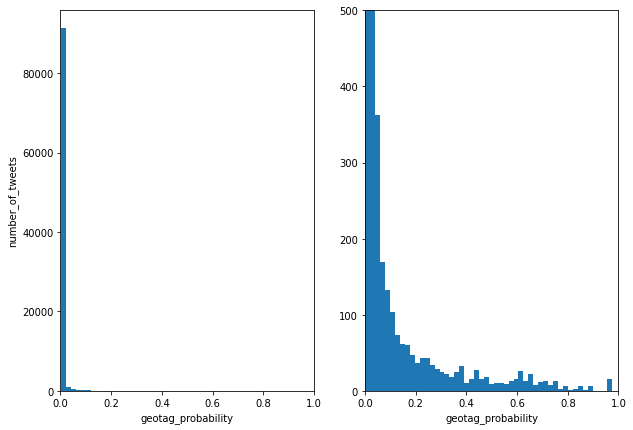

In [ ]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize =(10, 7))
axs[0].set_xlim(0, 1)
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 500)
axs[0].hist(test_data['geotag_probability'], bins=50)
axs[1].hist(test_data['geotag_probability'], bins=50)
axs[0].set_xlabel('geotag_probability')
axs[1].set_xlabel('geotag_probability')
axs[0].set_ylabel('number_of_tweets')
plt.show()

In [ ]:
BASE = 1000
NUM = 200
x = np.logspace(start=0, stop=1, base=BASE, num=NUM, endpoint=False)/BASE
#x = np.linspace(start=0, stop=0.99, num=500)
metrics_df = pd.DataFrame(columns=x, data=np.zeros((7, NUM)), index=['accuracy', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro', 'f1_macro', 'f1_micro'])
for x in metrics_df.columns:
  metrics_df[x] = get_metrics(test_data[test_data['geotag_probability'] > x])
metrics_df.T

,accuracy,precision_macro,precision_micro,recall_macro,recall_micro,f1_macro,f1_micro
0.001000,0.331904,0.480548,0.331904,0.264837,0.331904,0.318474,0.331904
0.001035,0.331904,0.480548,0.331904,0.264837,0.331904,0.318474,0.331904
0.001072,0.331904,0.480548,0.331904,0.264837,0.331904,0.318474,0.331904
0.001109,0.331904,0.480548,0.331904,0.264837,0.331904,0.318474,0.331904
0.001148,0.331904,0.480548,0.331904,0.264837,0.331904,0.318474,0.331904
...,...,...,...,...,...,...,...
0.841395,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.870964,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.901571,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.933254,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


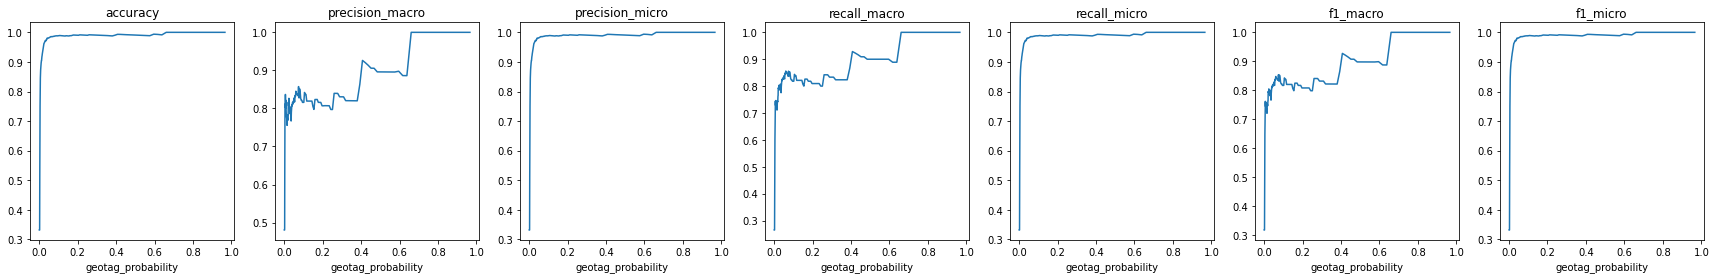

In [ ]:
fig, axs = plt.subplots(1, 7, figsize =(30, 4))
for i in range(7):
  column = metrics_df.T.columns[i]
  axs[i].plot(metrics_df.T.index, metrics_df.T[column], label=column)
  axs[i].set_title(column)
  axs[i].set_xlabel('geotag_probability')
plt.show()

Confidence score value function was chosen to replicate accuracy metric. So if a geotag has confidence value 70 then it means that it is 70% accurate.

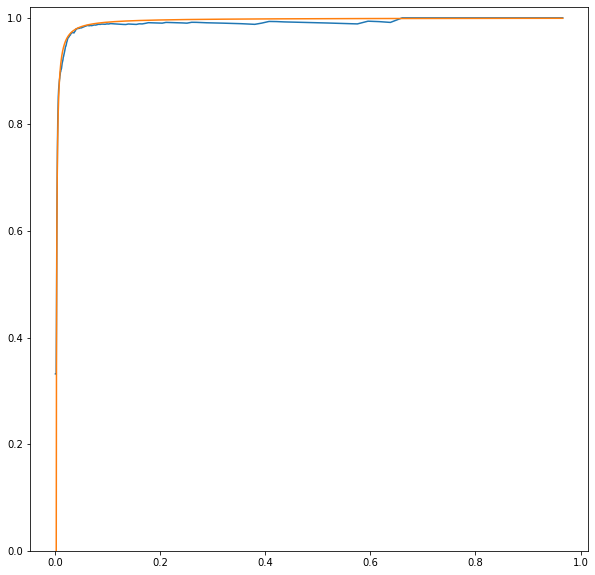

In [ ]:
fig, axs = plt.subplots(1, figsize =(10, 10))
score = lambda x: -1/pow(1200*(x - 1/NUMBER_OF_AREAS) + 1, 1.01) + 1
axs.set_ylim(0, 1.02)
#axs.set_xlim(0, 0.1)
axs.plot(metrics_df.T.index, metrics_df.T['accuracy'])
axs.plot(metrics_df.T.index, score(metrics_df.T.index))
plt.show()

###Code for the validation dataset not shared in the challenge

In [ ]:
CSV_FILE_NAME = None # write a path and a name of evaluation dataset

if CSV_FILE_NAME is not None:
  tweets_evaluation_df = pd.read_csv(CSV_FILE_NAME, on_bad_lines='skip')
  tweets_evaluation_df.dropna(inplace=True)
  tweets_evaluation_df['is_lat'] = tweets_evaluation_df['lat'].apply(is_number)
  tweets_evaluation_df['is_lon'] = tweets_evaluation_df['lon'].apply(is_number)
  tweets_evaluation_df['columns_to_drop'] = ~(tweets_evaluation_df['is_lat'] & tweets_evaluation_df['is_lon'])
  tweets_evaluation_df.drop(tweets_evaluation_df[tweets_evaluation_df['columns_to_drop']==True].index, inplace=True)
  tweets_evaluation_df.drop(['is_lat', 'is_lon', 'columns_to_drop'], axis=1, inplace=True)
  tweets_evaluation_df['lat'] = tweets_evaluation_df['lat'].apply(float)
  tweets_evaluation_df['lon'] = tweets_evaluation_df['lon'].apply(float)
  tweets_evaluation_df.drop(tweets_evaluation_df[tweets_evaluation_df['lat'] > 90].index, inplace=True)
else: # if the data is not provided then a validation dataset from a given one is used
  tweets_evaluation_df = tweets_df.loc[X_validation.index]

tweets_evaluation_df = get_predictions(tweets_evaluation_df)
tweets_evaluation_df.sample(n=25)

,tweet_text,lang,timestamp,lat,lon,geotag,predicted_geotag,geotag_probability,confidence_score
2648493,Happy birthday to #ab_salyann_da_god aka @zile...,ht,2021-08-07T18:34:14.000Z,19.055430,-73.054142,69,14,0.003216,46.6
3458724,@afsararab2 @IndianEmbRiyadh @drausaf @JM_Scin...,en,2021-08-06T12:38:06.000Z,28.835324,78.241576,74,74,0.004212,67.6
3159628,Mood🤤🤤🤤😍🥺 https://t.co/cWviwWP8qV,en,2021-08-02T04:03:39.000Z,28.299370,-81.402347,187,237,0.002636,14.1
417385,@99aviary https://t.co/C4QCLUjnwg so was it Ne...,en,2021-08-08T04:09:59.000Z,28.545556,77.498726,74,74,0.002909,33.2
2983052,Este vato me trajo toda la semana con el mismo...,es,2021-08-14T15:05:48.000Z,23.468140,-106.271748,196,41,0.003526,55.5
4052718,"Buen viernes.""",es,2021-08-06T16:47:01.000Z,20.715275,-100.440595,95,192,0.002763,24.2
4967991,Cost of office cleaning in Nairobi and factors...,en,2021-08-19T16:41:00.000Z,-1.274863,36.863620,13,13,0.004126,66.5
4494941,@mis_minky Mbeya again??,in,2021-08-30T08:13:15.000Z,-6.878811,39.282390,133,133,0.003078,41.2
5270528,@durwoodg @RyRousseau God' Mercy Children Foun...,en,2021-08-05T07:49:08.000Z,0.449087,32.034724,121,121,0.003273,48.5
4197626,#felizdiadospais #papaievovôfeliz em Planaltin...,pt,2021-08-08T18:00:04.000Z,-15.776254,-47.796623,90,90,0.003582,56.9


In [ ]:
get_metrics(tweets_evaluation_df[tweets_evaluation_df['confidence_score'] > 70])

accuracy           0.715779
precision_macro    0.782276
precision_micro    0.715779
recall_macro       0.586544
recall_micro       0.715779
f1_macro           0.635357
f1_micro           0.715779
dtype: float64

Try out a random tweet from validation dataset

In [ ]:
PLOT_TYPE = 'POINT' # POINT or HEATMAP

tweet_to_show = tweets_evaluation_df[tweets_evaluation_df['confidence_score'] > 70].sample(n=1)
#tweet_to_show = tweets_evaluation_df[tweets_evaluation_df['confidence_score'] < 30].sample(n=1)
map = folium.Map(location = [15,30], tiles='Cartodb dark_matter', zoom_start = 2)

true_point = [tweet_to_show.lat, tweet_to_show.lon]
folium.Marker(true_point, popup='{}'.format(tweet_to_show.tweet_text.values[0]), icon=folium.Icon(color='green')).add_to(map)

if PLOT_TYPE == 'POINT':
  predicted_point = [cluster_centers_df.loc[tweet_to_show.predicted_geotag].lat, cluster_centers_df.loc[tweet_to_show.predicted_geotag].lon]
  folium.Marker(predicted_point, popup='Predicted location\nConfidence score {}'.format(tweet_to_show.confidence_score.values[0]), icon=folium.Icon(color='blue')).add_to(map)
elif PLOT_TYPE == 'HEATMAP':
  plugins.HeatMap(get_geometry(tweets_df[tweets_df['geotag'] == tweet_to_show.predicted_geotag.values[0]])).add_to(map)

map